# 第15章 生存分析


## 15.1 生存データ

### データの読み込み

In [17]:
import polars as pl

# id: id
# rx: 治療(1 = プラシーボ, 2 = チオテパ)
# number: 最初の腫瘍の数(8は8以上)
# size: 最初の腫瘍の最大サイズ[cm]
# stop: 再発または打ち切りが、いつ発生したか
# event: 膀胱癌の再発(0: No, 1: Yes)
# enum: 再発が何回目か(4まで)
bladder = pl.read_csv("../data/bladder.csv")
display(bladder.head())

display(bladder["rx"].value_counts())

id,rx,number,size,stop,event,enum
i64,i64,i64,i64,i64,i64,i64
1,1,1,3,1,0,1
1,1,1,3,1,0,2
1,1,1,3,1,0,3
1,1,1,3,1,0,4
2,1,2,1,4,0,1


rx,counts
i64,u32
2,152
1,188


## 15.2 カプランマイヤー曲線

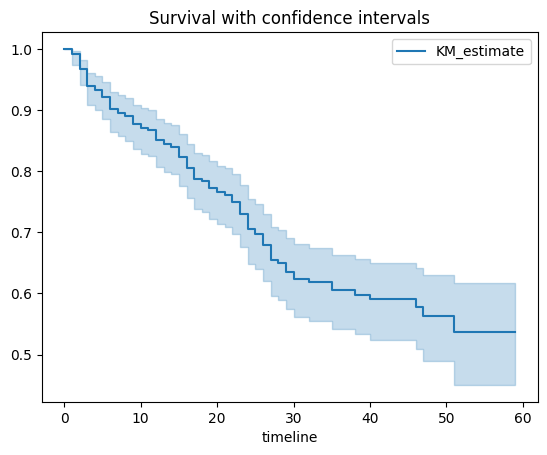

In [18]:
from lifelines import KaplanMeierFitter

# 学習
kmf = KaplanMeierFitter()
kmf.fit(bladder["stop"], event_observed = bladder["event"])

# 生存曲線を描画する
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
kmf.plot(ax = ax)
ax.set_title("Survival with confidence intervals")
plt.show()

## 15.3 Coxの比例ハザードモデル

In [19]:
from lifelines import CoxPHFitter

# 学習に使用する列を抽出する
df_study = bladder[["rx", "number", "size", "enum", "stop", "event"]]

# 学習する
cph = CoxPHFitter()
cph.fit(df_study.to_pandas(), duration_col = "stop", event_col = "event")

# 学習結果を表示する
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 340 total observations, 228 right-censored observations>
             duration col = 'stop'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 340
number of events observed = 112
   partial log-likelihood = -565.66
         time fit was run = 2024-01-01 11:43:37 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
rx         -0.60       0.55       0.20            -0.99            -0.20                 0.37                 0.82
number      0.22       1.24       0.05             0.13             0.31                 1.13                 1.36
size       -0.06       0.94       0.07            -0.20             0.08                 0.82                 1.09
enum       -0.60       0.55       0.09            -0.79            -0.42                 0.45                 0.66

            cmp to     z      p   -log2(p)
covariate                                 
rx            0.00 -2.97 <0.005       8.41
number        0.00  4.68 <0.005      18.38
size          0.00 -0.80   0.42       1.24
enum          0.00 -6.42 <0.005      32.80
---
Concordance = 0.75
Partial AIC = 1139.32
log-likelihood ratio test = 67.21 on 4 df
-log2(p) of ll-ratio test = 43.37

## 15.3 Coxの比例ハザードモデル

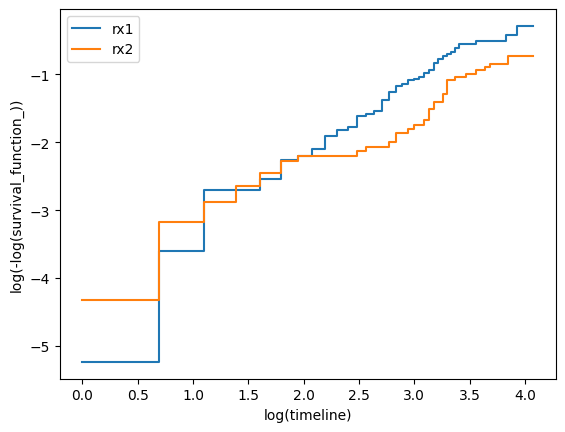

In [20]:
# 1 = プラシーボ
# 2 = チオテパ
rx1 = bladder.filter( pl.col("rx") == 1 )
rx2 = bladder.filter( pl.col("rx") == 2 )

# 層別に生存曲線を学習する
kmf1 = KaplanMeierFitter()
kmf1.fit(rx1["stop"], event_observed = rx1["event"])

kmf2 = KaplanMeierFitter()
kmf2.fit(rx2["stop"], event_observed = rx2["event"])

# 生存曲線を描画する
fig, axes = plt.subplots()

kmf1.plot_loglogs(ax = axes)
kmf2.plot_loglogs(ax = axes)

axes.legend(["rx1", "rx2"])

plt.show()

In [21]:
cph_strat = CoxPHFitter()
cph_strat.fit(
    df_study.to_pandas(),
    duration_col = "stop",
    event_col = "event",
    strata = ["rx"]
)
cph_strat.print_summary()

<lifelines.CoxPHFitter: fitted with 340 total observations, 228 right-censored observations>
             duration col = 'stop'
                event col = 'event'
                   strata = rx
      baseline estimation = breslow
   number of observations = 340
number of events observed = 112
   partial log-likelihood = -493.52
         time fit was run = 2024-01-01 11:43:38 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
number      0.21       1.24       0.05             0.12             0.30                 1.13                 1.36
size       -0.05       0.95       0.07            -0.19             0.08                 0.82                 1.09
enum       -0.61       0.55       0.09            -0.79            -0.42                 0.45                 0.66

            cmp to     z      p   -log2(p)
covariate                                 
number        0.00  4.60 <0.005      17.84
size          0.00 -0.77   0.44       1.19
enum          0.00 -6.45 <0.005      33.07
---
Concordance = 0.74
Partial AIC = 993.04
log-likelihood ratio test = 61.84 on 3 df
-log2(p) of ll-ratio test = 41.93